In [2]:
# ----------------------------------------------------------------------------
#
# TITLE - marginalize_linear_model.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Perform the linear algebra to marginalize the linear model of Hogg+ 2010 with a cosine term
'''

__author__ = "James Lane"

In [3]:
# General
import numpy as np
from scipy import linalg
import scipy as sc
from astropy.table import Table
import pdb, sys

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier

In [4]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Information
- paper: https://arxiv.org/abs/1008.4686

# About

We assume that the velocity fluctuations induced by the triaxial halo obeys the following restrictions:
- Only produces power in an m=2 mode
- Phase is constant with radius
- Smooth radial trend in power that tends to increase

Fit a simple linear model:

$
v_{T}(R,\phi) = v_{T,0}(R) + A_{T}(R) \cos \big[ 2( \phi - \phi_{b} ) \big] + N_{T}(R)
$

$
v_{R}(R,\phi) =  A_{R}(R) \sin \big[ 2( \phi - \phi_{b} ) \big] + N_{R}(R)
$

Likelihood looks like a gaussian offset from these models.

Likelihood of model parameters takes the form:

$
p(m,b \lvert D,\phi_{b}) \propto p(D \lvert m,b,\phi_{b})~p(\phi_{b} \lvert D)
$

Need to select $\phi_{b}$ in order for model to be linear

$
p(\phi_{b} \lvert D) \propto \int dm\ db\ p(D \lvert m,b,\phi_{b})
$

- Determine a fixed $\phi_{b}$
- Calculate $m=2$ amplitudes as a function radius
- Compare $m=2$ amplitudes with models

# Prepare

## Functions

In [21]:
def _bootstrap_in_phi(gc_R, gc_phi, gc_v, R_bin_cent, R_bin_size, phi_bin_cents, phi_bin_size, n_bs):
    '''_bootstrap_in_phi:
    
    Perform a bootstrap determination of the average velocity in phi bins.
    
    Args:
        gc_(R/phi/v) (float array) - Star properties
        R_bin_cent (float) - Radial bin center
        R_bin_size (float) - Radial bin size
        n_bs (int) - Number of bootstrap samples
    '''
    
    # Find all the points within this radial bin
    stars_in_R_bin = np.where( ( gc_R < R_bin_cent + R_bin_size/2 ) & 
                               ( gc_R > R_bin_cent - R_bin_size/2 ) )[0]
    n_stars_in_R_bin = len(stars_in_R_bin)
    gc_R_in_R_bin = gc_R[stars_in_R_bin]
    gc_phi_in_R_bin = gc_phi[stars_in_R_bin]
    gc_v_in_R_bin = gc_v[stars_in_R_bin]

    phi_bin_v = np.array([])
    phi_bin_v_err = np.array([])
    phi_bin_phi = np.array([])
    phi_bin_phi_err = np.array([])

    # Loop over phi bins
    for j in range(n_phi_bins):

        # Find all the points within this phi bin
        stars_in_phi_bin = np.where( ( gc_phi_in_R_bin < phi_bin_cents[j] + phi_bin_size/2 ) &
                                     ( gc_phi_in_R_bin > phi_bin_cents[j] - phi_bin_size/2 ) )[0]
        n_stars_in_phi_bin = len(stars_in_phi_bin)
        gc_R_in_phi_bin = gc_R_in_R_bin[stars_in_phi_bin]
        gc_phi_in_phi_bin = gc_phi_in_R_bin[stars_in_phi_bin]
        gc_v_in_phi_bin = gc_v_in_R_bin[stars_in_phi_bin]

        # If we have more than a certain number of stars then BS
        bs_v_avg_samps = np.array([])
        bs_phi_avg_samps = np.array([])
        if n_stars_in_phi_bin > 10:

            # Loop over BS samples
            for k in range(n_bs):
                sample = np.random.randint(0,n_stars_in_phi_bin,n_stars_in_phi_bin)
                bs_v_avg_samps = np.append( bs_v_avg_samps, np.average(gc_v_in_phi_bin[sample]) )
                bs_phi_avg_samps = np.append( bs_phi_avg_samps, np.average(gc_phi_in_phi_bin[sample]) )
            ###k
    
            # Append the mean to the list of measurements
            phi_bin_v = np.append( phi_bin_v, np.mean( bs_v_avg_samps ) )
            phi_bin_v_err = np.append( phi_bin_v, np.std( bs_v_avg_samps ) )
            phi_bin_phi = np.append( phi_bin_phi, np.mean( bs_phi_avg_samps ) )
            phi_bin_phi_err = np.append( phi_bin_phi_err, np.std( bs_phi_avg_samps ) )
        ##fi
    ###j
    
    return phi_bin_v, phi_bin_v_err, phi_bin_phi, phi_bin_phi_err
#def

def calculate_phib_likelihood(gc_R, gc_phi, gc_v, R_bin_cent, R_bin_size, phi_bin_cents, phi_bin_size, 
                              phib_bin_cents, n_bs=10, force_yint_zero=False, trig_function=np.cos, 
                              extra_variance=0):
    '''calculate_phib_likelihood:
    
    Calculate the likelihood given the linear model
    
    Args:
        Many
    
    Returns:
        Likelihood (float array) - Likelihood
    
    '''
    
    phi_bin_v, phi_bin_v_err, phi_bin_phi, phi_bin_phi_err = _bootstrap_in_phi(gc_R, gc_phi, gc_v, R_bin_cent, 
                                                                               R_bin_size, phi_bin_cents, 
                                                                               phi_bin_size, n_bs)

    # Now make the vectors
    n_good_phi_bins = len(phi_bin_v)
    Y = np.zeros((n_good_phi_bins,1))
    C = np.zeros((n_good_phi_bins,n_good_phi_bins))
    Y[:,0] = phi_bin_v
    for j in range(n_good_phi_bins):
        C[j,j] = phi_bin_v_err[j]**2 + extra_variance
    ###j
    C_inv = np.linalg.inv(C)

    # Now loop over all possible values of phi B, making the vector 
    # A for each and calculating the likelihood.
    n_phib_bins = len(phib_bin_cents)
    likelihood = np.zeros( n_phib_bins )
    for j in range(n_phib_bins):
        
        if force_yint_zero:
            A = np.ones((n_good_phi_bins,1))
            A[:,0] = trig_function( 2*( phi_bin_phi - phib_bin_cents[j] ) )
        else:
            A = np.ones((n_good_phi_bins,2))
            A[:,1] = trig_function( 2*( phi_bin_phi - phib_bin_cents[j] ) )
        ##ie

        # Now compute the vectors which form the solution
        V_inv = np.linalg.multi_dot( [ A.T, C_inv, A ] )
        V = np.linalg.inv( V_inv )
        W = np.matmul( np.linalg.inv( np.linalg.multi_dot( [A.T,C_inv,A] ) ), np.linalg.multi_dot( [A.T,C_inv,Y] ) )
        U = np.linalg.multi_dot( [Y.T,C_inv,Y-np.matmul(A,W)] )
        likelihood[j] = np.sqrt( np.linalg.det(V)/np.linalg.det(C) ) * np.exp( -U/2 )
    ###j

    return likelihood

#def

def calculate_best_fit_m_b(gc_R, gc_phi, gc_v, R_bin_cent, R_bin_size, phi_bin_cents, phi_bin_size, phib, 
                           trig_function, n_bs=10, force_yint_zero=False, extra_variance=0):
    '''calculate_best_fitting_m_b:
    
    Args:
    
    Returns:
    
    '''
    phi_bin_v, phi_bin_v_err, phi_bin_phi, phi_bin_phi_err = _bootstrap_in_phi(gc_R, gc_phi, gc_v, R_bin_cent,
                                                                               R_bin_size, phi_bin_cents, 
                                                                               phi_bin_size, n_bs)

    # Now make the vectors
    n_good_phi_bins = len(phi_bin_v)
    Y = np.zeros((n_good_phi_bins,1))
    C = np.zeros((n_good_phi_bins,n_good_phi_bins))
    Y[:,0] = phi_bin_v
    for j in range(n_good_phi_bins):
        C[j,j] = phi_bin_v_err[j]**2 + extra_variance
    ###j
    C_inv = np.linalg.inv(C)
    
    # Check if the y intercept is forced to be 0
    if force_yint_zero:
        A = np.ones((n_good_phi_bins,1))
        A[:,0] = trig_function( 2*( phi_bin_phi - phib ) )
    else:
        A = np.ones((n_good_phi_bins,2))
        A[:,1] = trig_function( 2*( phi_bin_phi - phib ) )
    ##ie
    
    X = np.matmul( np.linalg.inv( np.linalg.multi_dot([A.T,np.linalg.inv(C),A]) ), np.linalg.multi_dot([A.T,np.linalg.inv(C),Y]) )
    SIG_X = np.linalg.inv( np.linalg.multi_dot([A.T,np.linalg.inv(C),A]) )
    return X, SIG_X
#def

def calculate_variance_data_model(gc_R, gc_phi, gc_v, R_bin_cent, R_bin_size, phi_bin_cents, phi_bin_size,
                                    n_bs, m, b, phib, trig_function):
    '''calculate_variance_data_model:
    '''
    phi_bin_v, phi_bin_v_err, phi_bin_phi, phi_bin_phi_err = _bootstrap_in_phi(gc_R, gc_phi, gc_v, R_bin_cent,
                                                                               R_bin_size, phi_bin_cents, 
                                                                               phi_bin_size, n_bs)
    
    # Calculate the model at the locations where there is data
    model_v = b + m*trig_function(2*(phi_bin_phi-phib))
    
    # Calculate the standard deviation of the differences between model and data
    sd_data_model = np.std(model_v-phi_bin_v)
    
    return np.square(sd_data_model)
    
#def

def radial_velocity_known_m_b_phi(R_bin_cents, R_bin_size, phi_range, phi_bin_size, gc_R, gc_phi, gc_v,
                            ms, bs, phib, trig_function, phi_bin_size_in_arc=True, zero_vels=False
                               ):
    '''radial_velocity_known_m_b_phi:
    
    
    '''
    
    n_R = len(R_bin_cents)
    
    # Declare the figure
    fig = plt.figure( figsize=(15,n_R*3) )
    axs = fig.subplots(nrows=n_R, ncols=3)
    
    # Loop over all radii
    for i in range( n_R ):
        
        # Select the stars in this bin
        stars_in_bin = np.where( (gc_R > (R_bin_cents[i]-R_bin_size/2) ) & 
                                 (gc_R < (R_bin_cents[i]+R_bin_size/2) ) )[0]
        gcR_in_bin = gc_R[stars_in_bin]
        gcv_in_bin = gc_v[stars_in_bin]
        gcphi_in_bin = gc_phi[stars_in_bin]

        if phi_bin_size_in_arc:
            # Bin the Gaia data in arc
            arc_min = phi_range[0]*R_bin_cents[i]
            arc_max = phi_range[1]*R_bin_cents[i]
            phi_bin_cents = np.arange( arc_min, arc_max, phi_bin_size)
            phi_bin_cents += ( ( arc_max - arc_min ) % phi_bin_size )/2
            phi_bin_cents /= R_bin_cents[i]
        else:
            phi_bin_cents = np.arange( phi_range[0], phi_range[1], phi_bin_size )
            phi_bin_cents += ( ( phi_range[1] - phi_range[0] ) % phi_bin_size )/2
        ##ie
        
        # Make the bin edges and bin velocity, R, and number in phi
        phi_bin_edges = np.append( phi_bin_cents-np.diff(phi_bin_cents)[0], 
                                   phi_bin_cents[-1]+np.diff(phi_bin_cents)[0] )
        binned_v, _, _ = binned_statistic(gcphi_in_bin, gcv_in_bin, bins=phi_bin_edges, statistic='mean')
        binned_R, _, _ = binned_statistic(gcphi_in_bin, gcR_in_bin, bins=phi_bin_edges, statistic='mean')        
        
        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_bin_edges)
        binned_n = binned_n.astype('float')
        min_N = 20
        where_low_bin_numbers = np.where(binned_n < min_N)
        binned_v[ where_low_bin_numbers ] = np.nan
        binned_R[ where_low_bin_numbers ] = np.nan
        binned_n[ where_low_bin_numbers ] = np.nan

        # Find where there was data
        where_data = np.where( np.isfinite(binned_v) )
        where_no_data = np.where( np.isnan(binned_v) )
        binned_v[ where_no_data ] = np.nan
        binned_R[ where_no_data ] = np.nan
        binned_n[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        if zero_vels:
            binned_v -= np.nanmean( binned_v[where_data] )
        
        axs[i,0].plot( phi_bin_cents, binned_v, linewidth=0.5, color='Black' )
        axs[i,1].plot( phi_bin_cents, binned_R, linewidth=0.5, color='Black' )
        axs[i,2].plot( phi_bin_cents, binned_n, linewidth=0.5, color='Black' )
        axs[i,0].scatter( phi_bin_cents, binned_v, s=5, color='Black' )
        axs[i,1].scatter( phi_bin_cents, binned_R, s=5, color='Black' )
        axs[i,2].scatter( phi_bin_cents, binned_n, s=5, color='Black' )
        
        axs[i,2].set_yscale("log", nonposy='clip')
        
        axs[i,0].annotate( r'$R_{cen}=$'+str(R_bin_cents[i])+' kpc', xy=(0.05,0.8), xycoords='axes fraction' )
        axs[i,1].set_ylim( R_bin_cents[i]-R_bin_size/2, R_bin_cents[i]+R_bin_size/2 )
        
        axs[i,0].set_xlim( phi_range[0], phi_range[1] )
        axs[i,1].set_xlim( phi_range[0], phi_range[1] )
        axs[i,2].set_xlim( phi_range[0], phi_range[1] )
        axs[i,2].set_ylim( 1, 5000)
        
        # Add a bar
        axs[i,0].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        axs[i,1].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        axs[i,2].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        
        axs[i,0].axhline( np.nanmean( binned_v[where_data] ), linestyle='dashed', linewidth=0.5 )
        axs[i,1].axhline( R_bin_cents[i], linestyle='dashed', linewidth=0.5 )
        axs[i,2].axhline( min_N, linestyle='dashed', linewidth=0.5 )
        
        axs[i,1].set_ylabel(r'$\bar{R}$ [kpc]')
        axs[i,2].set_ylabel(r'$N$')
        
        axs[i,0].set_xlabel(r'$\phi$')
        axs[i,1].set_xlabel(r'$\phi$')
        axs[i,2].set_xlabel(r'$\phi$')
        
        # Plot the best-fitting amplitude
        trig_phis = np.linspace(-np.pi/2, np.pi/2, num=100)
        
        n_phibs = len(phib)
        
        if n_phibs == 2:
            for j in range(2):
                axs[i,0].plot(trig_phis, bs[i,j]+ms[i,j]*trig_function(2*(trig_phis-phib[j])) )
            ###j
        else:
            axs[i,0].plot( trig_phis, bs[i][0]+ms[i][0]*trig_function(2*(trig_phis-phib[0])) )
        ##ie

    return fig, axs
#def

def radial_velocity(R_bin_cents, R_bin_size, phi_range, phi_bin_size, gc_R, gc_phi, gc_v,
                    likelihood, trig_function, phi_bin_size_in_arc=True
                   ):
    '''radial_velocity:
    
    
    '''
    
    n_R = len(R_bin_cents)
    
    # Declare the figure
    fig = plt.figure( figsize=(15,n_R*3) )
    axs = fig.subplots(nrows=n_R, ncols=3)
    
    # Loop over all radii
    for i in range( n_R ):
        
        # Select the stars in this bin
        stars_in_bin = np.where( (gc_R > (R_bin_cents[i]-R_bin_size/2) ) & 
                                 (gc_R < (R_bin_cents[i]+R_bin_size/2) ) )[0]
        gcR_in_bin = gc_R[stars_in_bin]
        gcv_in_bin = gc_v[stars_in_bin]
        gcphi_in_bin = gc_phi[stars_in_bin]

        if phi_bin_size_in_arc:
            # Bin the Gaia data in arc
            arc_min = phi_range[0]*R_bin_cents[i]
            arc_max = phi_range[1]*R_bin_cents[i]
            phi_bin_cents = np.arange( arc_min, arc_max, phi_bin_size)
            phi_bin_cents += ( ( arc_max - arc_min ) % phi_bin_size )/2
            phi_bin_cents /= R_bin_cents[i]
        else:
            phi_bin_cents = np.arange( phi_range[0], phi_range[1], phi_bin_size )
            phi_bin_cents += ( ( phi_range[1] - phi_range[0] ) % phi_bin_size )/2
        ##ie
        
        # Make the bin edges and bin velocity, R, and number in phi
        phi_bin_edges = np.append( phi_bin_cents-np.diff(phi_bin_cents)[0], 
                                   phi_bin_cents[-1]+np.diff(phi_bin_cents)[0] )
        binned_v, _, _ = binned_statistic(gcphi_in_bin, gcv_in_bin, bins=phi_bin_edges, statistic='mean')
        binned_R, _, _ = binned_statistic(gcphi_in_bin, gcR_in_bin, bins=phi_bin_edges, statistic='mean')        
        
        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_bin_edges)
        binned_n = binned_n.astype('float')
        min_N = 20
        where_low_bin_numbers = np.where(binned_n < min_N)
        binned_v[ where_low_bin_numbers ] = np.nan
        binned_R[ where_low_bin_numbers ] = np.nan
        binned_n[ where_low_bin_numbers ] = np.nan

        # Find where there was data
        where_data = np.where( np.isfinite(binned_v) )
        where_no_data = np.where( np.isnan(binned_v) )
        binned_v[ where_no_data ] = np.nan
        binned_R[ where_no_data ] = np.nan
        binned_n[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        # binned_v -= np.nanmean( binned_v[where_data] )
        
        axs[i,0].plot( phi_bin_cents, binned_v, linewidth=0.5, color='Black' )
        axs[i,1].plot( phi_bin_cents, binned_R, linewidth=0.5, color='Black' )
        axs[i,2].plot( phi_bin_cents, binned_n, linewidth=0.5, color='Black' )
        axs[i,0].scatter( phi_bin_cents, binned_v, s=5, color='Black' )
        axs[i,1].scatter( phi_bin_cents, binned_R, s=5, color='Black' )
        axs[i,2].scatter( phi_bin_cents, binned_n, s=5, color='Black' )
        
        axs[i,2].set_yscale("log", nonposy='clip')
        
        axs[i,0].annotate( r'$R_{cen}=$'+str(R_bin_cents[i])+' kpc', xy=(0.05,0.8), xycoords='axes fraction' )
        axs[i,1].set_ylim( R_bin_cents[i]-R_bin_size/2, R_bin_cents[i]+R_bin_size/2 )
        
        axs[i,0].set_xlim( phi_range[0], phi_range[1] )
        axs[i,1].set_xlim( phi_range[0], phi_range[1] )
        axs[i,2].set_xlim( phi_range[0], phi_range[1] )
        axs[i,2].set_ylim( 1, 5000)
        
        # Add a bar
        axs[i,0].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        axs[i,1].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        axs[i,2].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        
        axs[i,0].axhline( np.nanmean( binned_v[where_data] ), linestyle='dashed', linewidth=0.5 )
        axs[i,1].axhline( R_bin_cents[i], linestyle='dashed', linewidth=0.5 )
        axs[i,2].axhline( min_N, linestyle='dashed', linewidth=0.5 )
        
        axs[i,1].set_ylabel(r'$\bar{R}$ [kpc]')
        axs[i,2].set_ylabel(r'$N$')
        
        axs[i,0].set_xlabel(r'$\phi$')
        axs[i,1].set_xlabel(r'$\phi$')
        axs[i,2].set_xlabel(r'$\phi$')
        
        # Estimate the amplitude of the sinusoid
        amp_estimate = np.nanmax( np.abs( binned_v ) )
        
        # Find the maximum likelihood
        max_likelihood_ind = np.argmax( likelihood[i,:] )
        trig_phis = np.linspace(-np.pi/2, np.pi/2, num=100)
        
        # Plot the peak
        phib_lims = [-np.pi/2, np.pi/2]
        phib_bin_size = np.pi/20
        phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2
        axs[i,0].plot(trig_phis, amp_estimate*trig_function(2*(trig_phis-phib_bin_cents[max_likelihood_ind]-0)))
        # axs[i,0].plot(trig_phis, -amp_estimate*trig_function(2*(trig_phis-phib_bin_cents[max_likelihood_ind]-0)))

#         # Check if likelihoods are in log
#         if len( np.where( likelihood < 0 )[0] ) > 1:
#             likelihood = np.exp( likelihood )
        
#         # Sample from the likelihood
#         phib_lims = [-np.pi/2, np.pi/2]
#         phib_bin_size = np.pi/20
#         phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2
        
#         trig_phis = np.linspace(-np.pi/2, np.pi/2, num=100)
#         n_phib_samps = 0
#         phib_samps = np.zeros(n_phib_samps)
#         phib_samps_good = 0
#         while phib_samps_good < n_phib_samps:
#             # Pick a random phib between -np.pi/2 and np.pi/2
#             rand_phib = np.random.choice( phib_bin_cents, size=1 )[0]
#             rand_ind = np.where( phib_bin_cents == rand_phib )[0]
#             rand_likelihood = np.random.random(1)[0]
#             if rand_likelihood < likelihood[i,rand_ind]:
#                 axs[i,0].plot( trig_phis, amp_estimate * trig_function( 2*( trig_phis - rand_phib ) ), 
#                               linewidth=0.5, alpha=0.2, color='DodgerBlue')
#                 phib_samps_good += 1
#             else: 
#                 continue
#             ##ie
#         ##wh
    ###i

    return fig, axs
#def

## Load Data

In [6]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [7]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [8]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [9]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = np.sin(gc_phi)*gc_vx - np.cos(gc_phi)*gc_vy
gc_phi = np.arctan2(gc_y,-gc_x)

## Creating vectors

The solution to the equation with the $\chi^{2}$ term is:

$
\chi^2 = ({\bf X} - {\bf W})^T {\bf V}^{-1}\,({\bf X} - {\bf W}) + {\bf U}
$

with

$
W = [A^{T}C^{-1}A]^{-1}A^{T}C^{-1}Y
$

$
W^{T} = Y^{T}C^{-1}A[A^{T}C^{-1}A]^{-1}
$

$
V^{-1} = A^{T}C^{-1}A
$

and

$
U = Y^{T}C^{-1}[Y-AW]
$

The solution to the integral is:

$
p( \phi_{b} | Data ) \propto \sqrt{ \frac{ \det V }{ \det \Sigma } }\exp[-U/2]
$

First, create $\mathbf{A}$, a $N \times 2$ matric of $1$ and $\cos[2(\phi-\phi_{b})]$. Also create $\mathbf{Y}$, a column vector of velocity data points. Finally, make the covariance matrix after bootstrapping in bins.

# Loop over all radii

In [10]:
R_lims = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2
n_R_bins = len(R_bin_cents)

phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/20
phi_bin_cents = np.arange( phi_lims[0], phi_lims[1], phi_bin_size ) + phi_bin_size/2
n_phi_bins = len(phi_bin_cents)

phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/20
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2
n_phib_bins = len(phib_bin_cents)

# Tangential Velocity

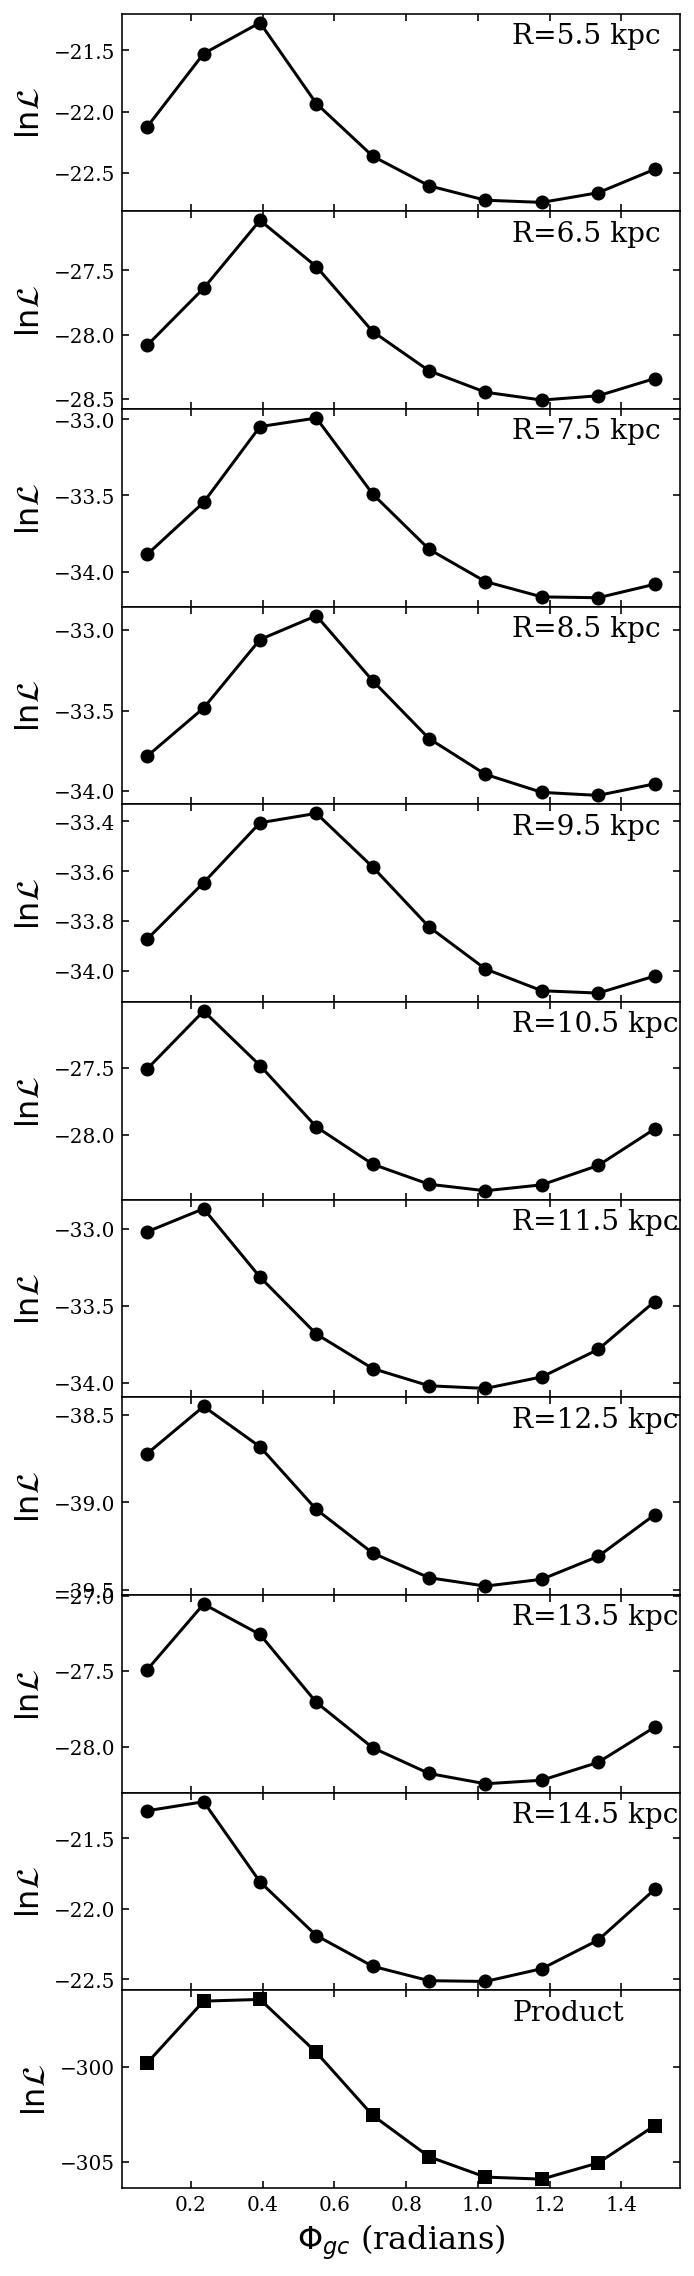

In [11]:
fig = plt.figure( figsize=(5,20) )
axs = fig.subplots( nrows=n_R_bins+1, ncols=1 )

store_likelihood_vT = np.ones( ( n_R_bins, n_phib_bins ) )

for i in range(n_R_bins):
    
    likelihood = calculate_phib_likelihood(gc_R, gc_phi, gc_vT, R_bin_cents[i], R_bin_size, phi_bin_cents, 
                                           phi_bin_size, phib_bin_cents, n_bs=50,
                                           force_yint_zero=False, trig_function=np.cos)
    
    store_likelihood_vT[i,:] = np.log(likelihood)

    # Plot
    axs[i].plot( phib_bin_cents, np.log(likelihood), marker='o', color='Black' )
    axs[i].annotate('R='+str(R_bin_cents[i])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
    axs[i].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
    axs[i].tick_params(labelbottom='off')
    ##fi

# Marginalize over all radii
prod_likelihood_vT = np.sum(store_likelihood_vT, axis=0)

# Plot
axs[-1].plot( phib_bin_cents, prod_likelihood_vT, marker='s', color='Black' )
axs[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
axs[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16) 

#
axs[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
fig.subplots_adjust(hspace=0)
plt.show()
pass;

# Radial velocity

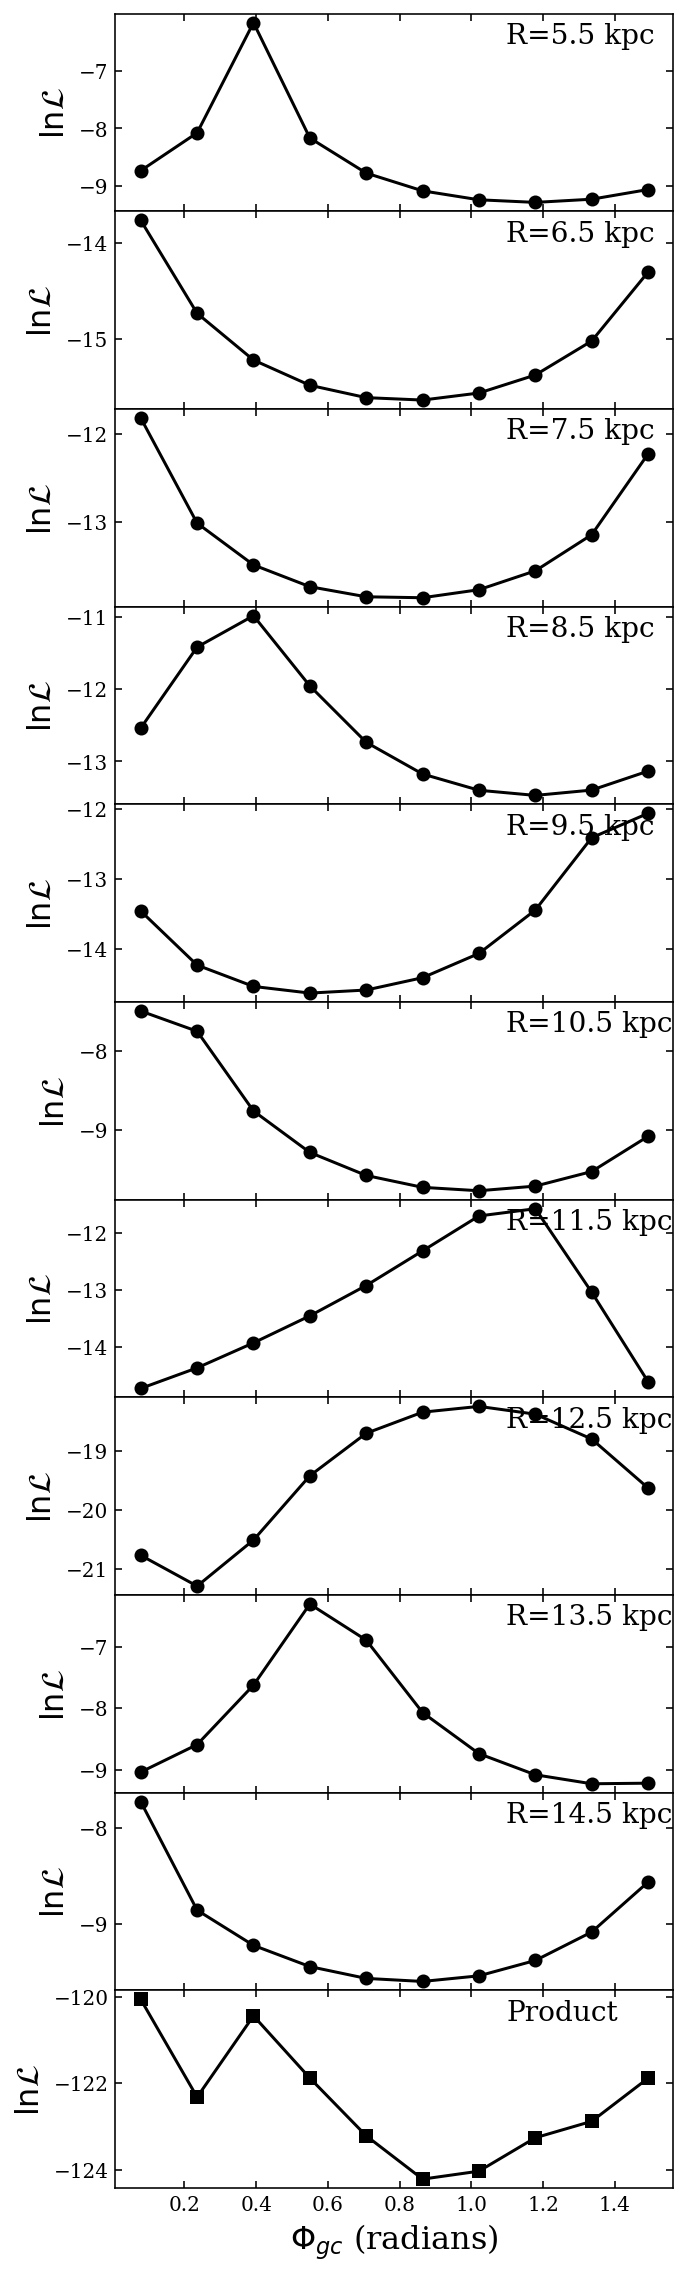

In [12]:
fig = plt.figure( figsize=(5,20) )
axs = fig.subplots( nrows=n_R_bins+1, ncols=1 )

store_likelihood_vR = np.ones( ( n_R_bins, n_phib_bins ) )

for i in range(n_R_bins):
    
    
    likelihood = calculate_phib_likelihood(gc_R, gc_phi, gc_vR, R_bin_cents[i], R_bin_size, phi_bin_cents, 
                                           phi_bin_size, phib_bin_cents, n_bs=50,
                                           force_yint_zero=True, trig_function=np.sin)
    store_likelihood_vR[i,:] = np.log(likelihood)
        
    # Plot
    axs[i].plot( phib_bin_cents, np.log(likelihood), marker='o', color='Black' )
    axs[i].annotate('R='+str(R_bin_cents[i])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
    axs[i].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
    axs[i].tick_params(labelbottom='off')
    ##fi

prod_likelihood_vR = np.sum(store_likelihood_vR, axis=0)

axs[-1].plot( phib_bin_cents, prod_likelihood_vR, marker='s', color='Black' )
axs[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
axs[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)     

axs[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
fig.subplots_adjust(hspace=0)
plt.show()
pass;

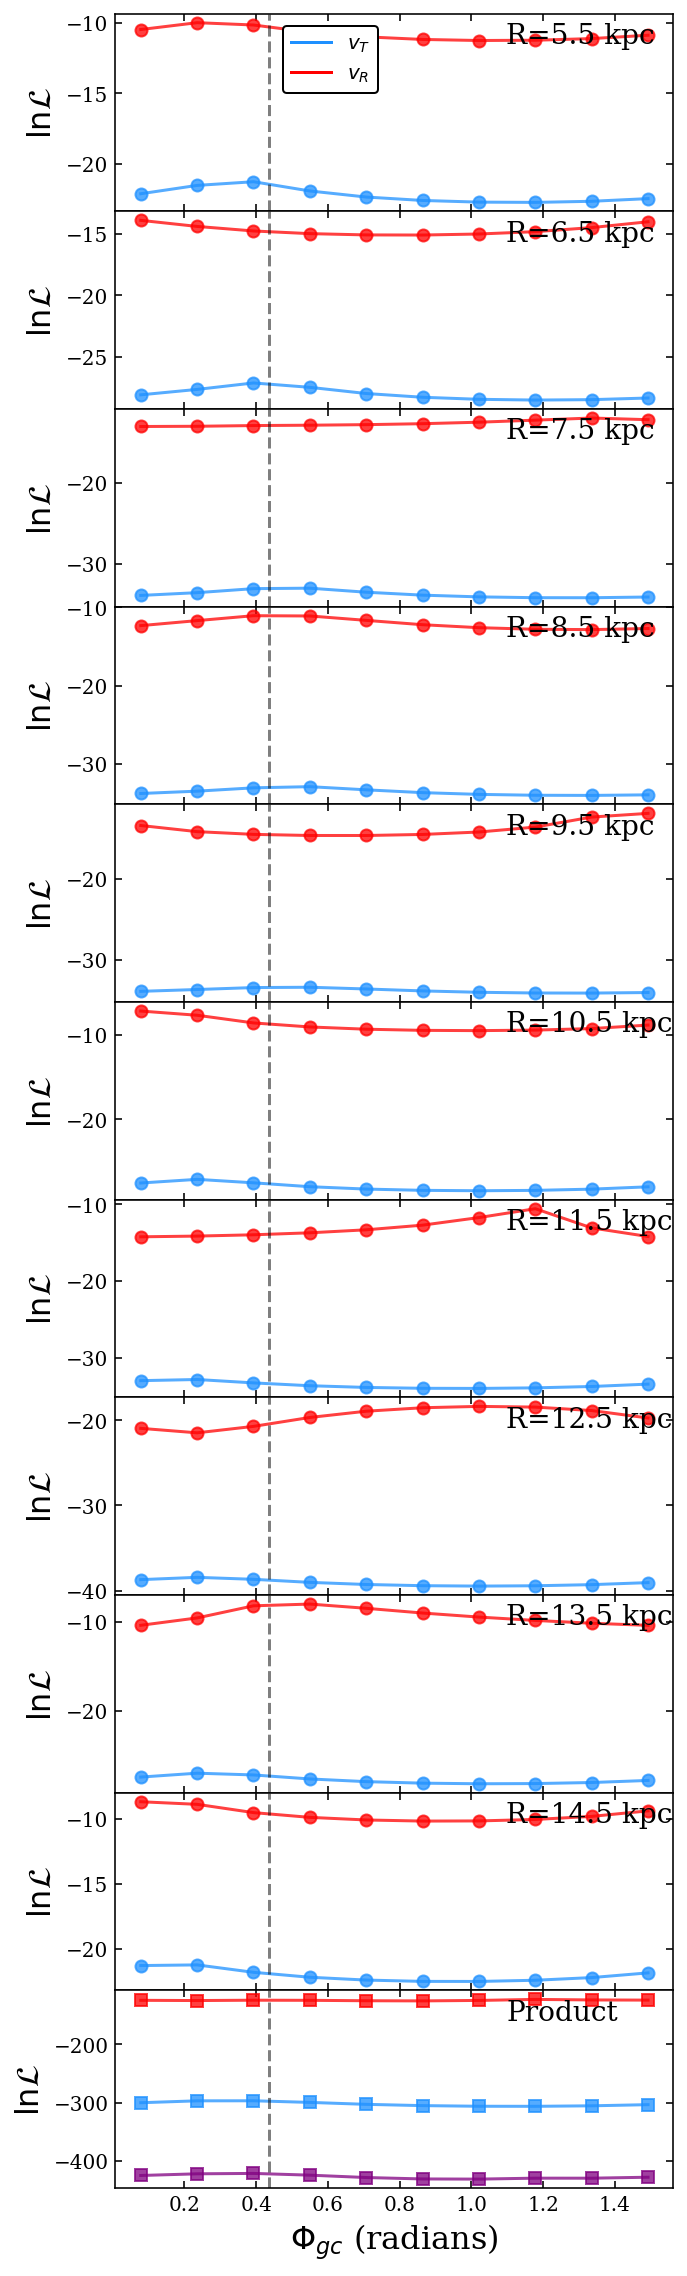

In [13]:
fig = plt.figure( figsize=(5,20) )
axs = fig.subplots( nrows=n_R_bins+1, ncols=1 )

store_likelihood_vR = np.ones( ( n_R_bins, n_phib_bins ) )
store_likelihood_vT = np.ones( ( n_R_bins, n_phib_bins ) )

for i in range(n_R_bins):
    
    likelihood_vT = calculate_phib_likelihood(gc_R, gc_phi, gc_vT, R_bin_cents[i], R_bin_size, phi_bin_cents, 
                                              phi_bin_size, phib_bin_cents, n_bs=50,
                                              force_yint_zero=False, trig_function=np.cos)
    store_likelihood_vT[i,:] = np.log(likelihood_vT)
    
    likelihood_vR = calculate_phib_likelihood(gc_R, gc_phi, gc_vR, R_bin_cents[i], R_bin_size, phi_bin_cents, 
                                              phi_bin_size, phib_bin_cents, n_bs=50,
                                              force_yint_zero=True, trig_function=np.sin)
    store_likelihood_vR[i,:] = np.log(likelihood_vR)
        
    # Plot
    axs[i].plot( phib_bin_cents, np.log(likelihood_vT), marker='o', color='DodgerBlue', alpha=0.75 )
    axs[i].plot( phib_bin_cents, np.log(likelihood_vR), marker='o', color='Red', alpha=0.75 )
    axs[i].annotate('R='+str(R_bin_cents[i])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
    axs[i].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
    axs[i].axvline( np.pi*25/180, color='Black', linestyle='dashed', alpha=0.5 )
    axs[i].tick_params(labelbottom='off')
    ##fi

axs[0].plot([], [], color='DodgerBlue', label=r'$v_{T}$')
axs[0].plot([], [], color='Red', label=r'$v_{R}$')
axs[0].legend(loc=(0.3,0.6))
    
prod_likelihood_vT = np.sum(store_likelihood_vT, axis=0)
prod_likelihood_vR = np.sum(store_likelihood_vR, axis=0)
prod_likelihood_both = prod_likelihood_vR + prod_likelihood_vT

axs[-1].plot( phib_bin_cents, prod_likelihood_vT, marker='s', color='DodgerBlue', alpha=0.75 )
axs[-1].plot( phib_bin_cents, prod_likelihood_vR, marker='s', color='Red', alpha=0.75 )
axs[-1].plot( phib_bin_cents, prod_likelihood_both, marker='s', color='Purple', alpha=0.75 )
axs[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
axs[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
axs[-1].axvline( np.pi*25/180, color='Black', linestyle='dashed', alpha=0.5 )

axs[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
fig.subplots_adjust(hspace=0)
plt.show()
pass;

# Best-fitting radial profile
Use the combined likelihood to determine the best-fitting radial profile

Since we now know $\phi_{b}$ we can simply use the linear algebra solution to determine the amplitude coeffients in each radial bin

In [14]:
# Find all the points within this radial bin
def determine_best_fitting_m_b(gc_R, gc_phi, gc_v, R_bin_cent, R_bin_size, phib, n_bs=10, force_yint_zero=False,
                              trig_function=np.cos, zero_vels=False):
    '''determine_best_fitting_m_b:
    
    Args:
    
    Returns:
    
    '''
    stars_in_R_bin = np.where( ( gc_R < R_bin_cent + R_bin_size/2 ) & 
                               ( gc_R > R_bin_cent - R_bin_size/2 ) )[0]
    n_stars_in_R_bin = len(stars_in_R_bin)
    gc_R_in_R_bin = gc_R[stars_in_R_bin]
    gc_phi_in_R_bin = gc_phi[stars_in_R_bin]
    gc_v_in_R_bin = gc_v[stars_in_R_bin]    
    
    phi_bin_v = np.array([])
    phi_bin_v_err = np.array([])
    phi_bin_phi = np.array([])
    phi_bin_phi_err = np.array([])

    # Loop over phi bins
    for j in range(n_phi_bins):

        # Find all the points within this phi bin
        stars_in_phi_bin = np.where( ( gc_phi_in_R_bin < phi_bin_cents[j] + phi_bin_size/2 ) &
                                     ( gc_phi_in_R_bin > phi_bin_cents[j] - phi_bin_size/2 ) )[0]
        n_stars_in_phi_bin = len(stars_in_phi_bin)
        gc_R_in_phi_bin = gc_R_in_R_bin[stars_in_phi_bin]
        gc_phi_in_phi_bin = gc_phi_in_R_bin[stars_in_phi_bin]
        gc_v_in_phi_bin = gc_v_in_R_bin[stars_in_phi_bin]

        # If we have more than a certain number of stars then BS
        bs_v_avg_samps = np.array([])
        bs_phi_avg_samps = np.array([])
        if n_stars_in_phi_bin > 10:

            # Loop over BS samples
            for k in range(n_bs):
                sample = np.random.randint(0,n_stars_in_phi_bin,n_stars_in_phi_bin)
                bs_v_avg_samps = np.append( bs_v_avg_samps, np.average(gc_v_in_phi_bin[sample]) )
                bs_phi_avg_samps = np.append( bs_phi_avg_samps, np.average(gc_phi_in_phi_bin[sample]) )
            ###k
    
            # Append the mean to the list of measurements
            phi_bin_v = np.append( phi_bin_v, np.mean( bs_v_avg_samps ) )
            phi_bin_v_err = np.append( phi_bin_v, np.std( bs_v_avg_samps ) )
            phi_bin_phi = np.append( phi_bin_phi, np.mean( bs_phi_avg_samps ) )
            phi_bin_phi_err = np.append( phi_bin_phi_err, np.std( bs_phi_avg_samps ) )
        ##fi
    ###j
    
    if zero_vels:
        phi_bin_v -= np.nanmean(phi_bin_v)

    # Now make the vectors
    n_good_phi_bins = len(phi_bin_v)
    Y = np.zeros((n_good_phi_bins,1))
    C = np.zeros((n_good_phi_bins,n_good_phi_bins))

    Y[:,0] = phi_bin_v
    for j in range(n_good_phi_bins):
        C[j,j] = phi_bin_v_err[j]**2
    ###j
    C_inv = np.linalg.inv(C)
    
    # Make sure to check if the y intercept is forced to be 0
    if force_yint_zero:
        A = np.ones((n_good_phi_bins,1))
        A[:,0] = trig_function( 2*( phi_bin_phi - phib ) )
    else:
        A = np.ones((n_good_phi_bins,2))
        A[:,1] = trig_function( 2*( phi_bin_phi - phib ) )
    ##ie
    
    X = np.matmul( np.linalg.inv( np.linalg.multi_dot([A.T,np.linalg.inv(C),A]) ), np.linalg.multi_dot([A.T,np.linalg.inv(C),Y]) )
    SIG_X = np.linalg.inv( np.linalg.multi_dot([A.T,np.linalg.inv(C),A]) )
    return X, SIG_X
#def

# Tangential velocity

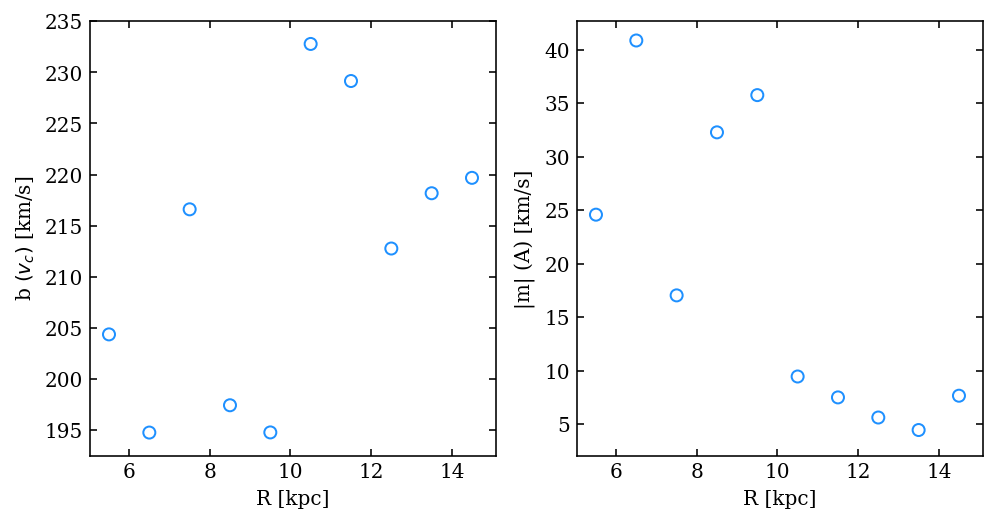

In [15]:
# Figure out the maximum likelihood
where_likelihood_max = np.where( prod_likelihood_both > np.max(prod_likelihood_both)-1.0E-9 )[0]
phib_max = phib_bin_cents[ where_likelihood_max ]

n_phib_max = len(phib_max)

fig = plt.figure( figsize=(8,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

vT_amps = np.zeros(())
vT_bs = np.zeros(())

for i in range(n_R_bins):
    for j in range( n_phib_max ):
        X, SIG_X = determine_best_fitting_m_b(gc_R, gc_phi, gc_vT, R_bin_cents[i], R_bin_size, phib_max[j], 
                                              n_bs=100, force_yint_zero=False, trig_function=np.cos)
        if j == 0:
            ax1.scatter(R_bin_cents[i], X[0], 
                         edgecolor='DodgerBlue', facecolor='None')
            ax2.scatter(R_bin_cents[i], np.abs(X[1]),
                         edgecolor='DodgerBlue', facecolor='None')
#             ax1.errorbar(R_bin_cents[i], X[0], yerr=np.sqrt(SIG_X[0,0]), 
#                          markeredgecolor='DodgerBlue', markerfacecolor='None')
#             ax2.errorbar(R_bin_cents[i], np.abs(X[1]), yerr=np.sqrt(SIG_X[1,1]),
#                          markeredgecolor='DodgerBlue', markerfacecolor='None')
        ##fi
        if j == 1:
            ax1.scatter(R_bin_cents[i], X[0], 
                         edgecolor='Red', facecolor='None')
            ax2.scatter(R_bin_cents[i], np.abs(X[1]),
                         edgecolor='Red', facecolor='None')
#             ax1.errorbar(R_bin_cents[i], X[0], yerr=np.sqrt(SIG_X[0,0]), 
#                          markeredgecolor='Red', markerfacecolor='None')
#             ax2.errorbar(R_bin_cents[i], np.abs(X[1]), yerr=np.sqrt(SIG_X[1,1]), 
#                          markeredgecolor='Red', markerfacecolor='None')
        ##fi
    ###j
###i

ax1.set_xlabel('R [kpc]')
ax1.set_ylabel(r'b $(v_{c})$ [km/s]')

ax2.set_xlabel('R [kpc]')
ax2.set_ylabel(r'|m| (A) [km/s]')

plt.show()
pass;

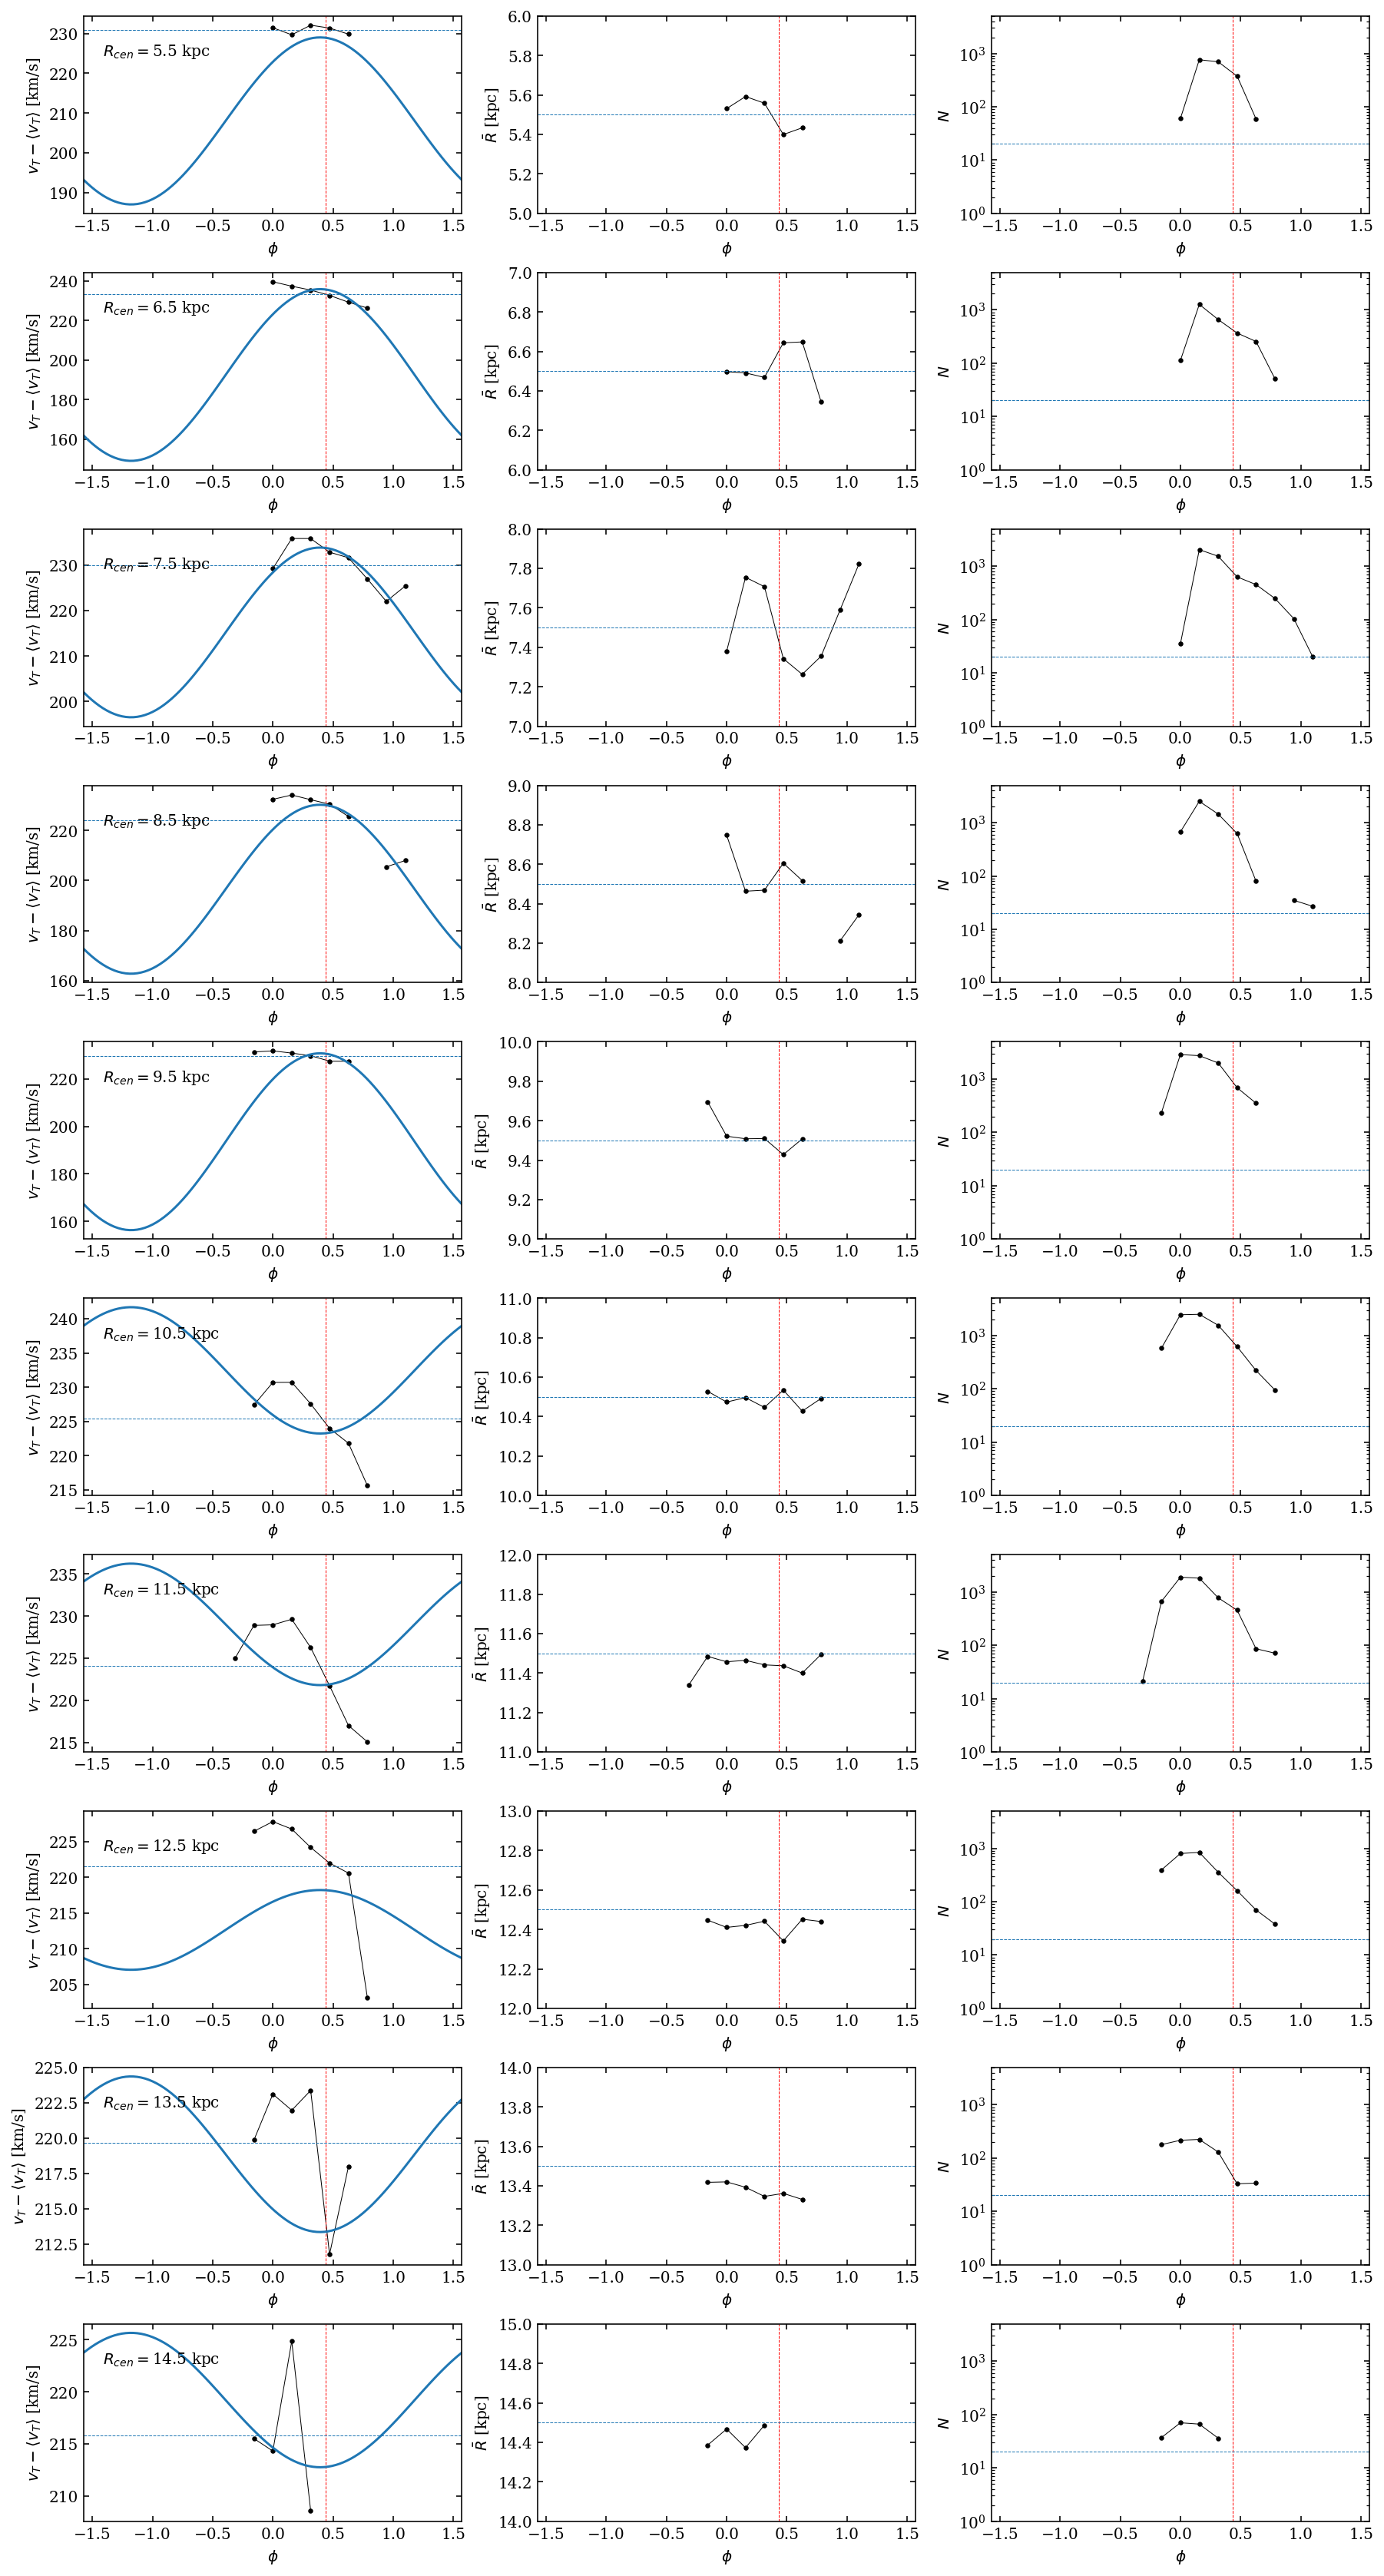

In [22]:
vT_amps = np.zeros(( n_R_bins, 2 ))
vT_bs = np.zeros(( n_R_bins, 2 ))

for i in range(n_R_bins):
    for j in range( n_phib_max ):
        X, SIG_X = determine_best_fitting_m_b(gc_R, gc_phi, gc_vT, R_bin_cents[i], R_bin_size, phib_max[j], 
                                              n_bs=100, force_yint_zero=False, trig_function=np.cos)
        vT_bs[i,j] = X[0]
        vT_amps[i,j] = X[1]
    ###j
###i

fig, axs = radial_velocity_known_m_b_phi( R_bin_cents, R_bin_size, phi_lims, phi_bin_size, gc_R, gc_phi, gc_vT,
                            vT_amps, vT_bs, phib_max, np.cos,
                            phi_bin_size_in_arc=False)

for i in range( len(R_bin_cents) ):
    axs[i,0].set_ylabel(r'$v_{T}- \langle v_{T} \rangle$ [km/s]')
##ax

fig.subplots_adjust( wspace=0.2, hspace=0.3 )

plt.show()

# Radial Velocity

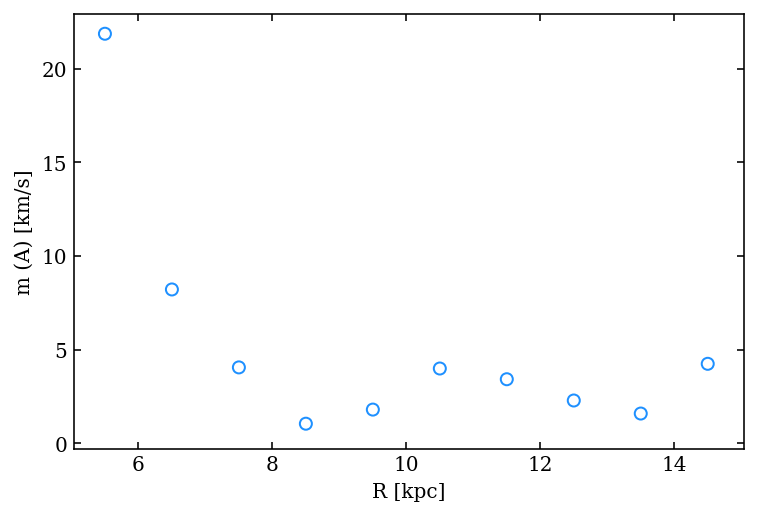

In [23]:
# Figure out the maximum likelihood
where_likelihood_max = np.where( prod_likelihood_both > np.max(prod_likelihood_both)-1.0E-9 )[0]
phib_max = phib_bin_cents[ where_likelihood_max ]

n_phib_max = len(phib_max)

fig = plt.figure( figsize=(6,4) )
ax1 = fig.add_subplot(111)

vT_amps = np.zeros(())
vT_bs = np.zeros(())

for i in range(n_R_bins):
    for j in range( n_phib_max ):
        X, SIG_X = determine_best_fitting_m_b(gc_R, gc_phi, gc_vR, R_bin_cents[i], R_bin_size, phib_max[j], 
                                              n_bs=100, force_yint_zero=True, trig_function=np.sin, zero_vels=True)
        if j == 0:
            ax1.scatter(R_bin_cents[i], np.abs(X[0]), 
                         edgecolor='DodgerBlue', facecolor='None')
#             ax2.scatter(R_bin_cents[i], np.abs(X[1]),
#                          edgecolor='DodgerBlue', facecolor='None')
#             ax1.errorbar(R_bin_cents[i], X[0], yerr=np.sqrt(SIG_X[0,0]), 
#                          markeredgecolor='DodgerBlue', markerfacecolor='None')
#             ax2.errorbar(R_bin_cents[i], np.abs(X[1]), yerr=np.sqrt(SIG_X[1,1]),
#                          markeredgecolor='DodgerBlue', markerfacecolor='None')
        ##fi
        if j == 1:
            ax1.scatter(R_bin_cents[i], np.abs(X[0]), 
                         edgecolor='Red', facecolor='None')
#             ax2.scatter(R_bin_cents[i], np.abs(X[1]),
#                          edgecolor='Red', facecolor='None')
#             ax1.errorbar(R_bin_cents[i], X[0], yerr=np.sqrt(SIG_X[0,0]), 
#                          markeredgecolor='Red', markerfacecolor='None')
#             ax2.errorbar(R_bin_cents[i], np.abs(X[1]), yerr=np.sqrt(SIG_X[1,1]), 
#                          markeredgecolor='Red', markerfacecolor='None')
        ##fi
    ###j
###i

ax1.set_xlabel('R [kpc]')
ax1.set_ylabel(r'm (A) [km/s]')

plt.show()
pass;

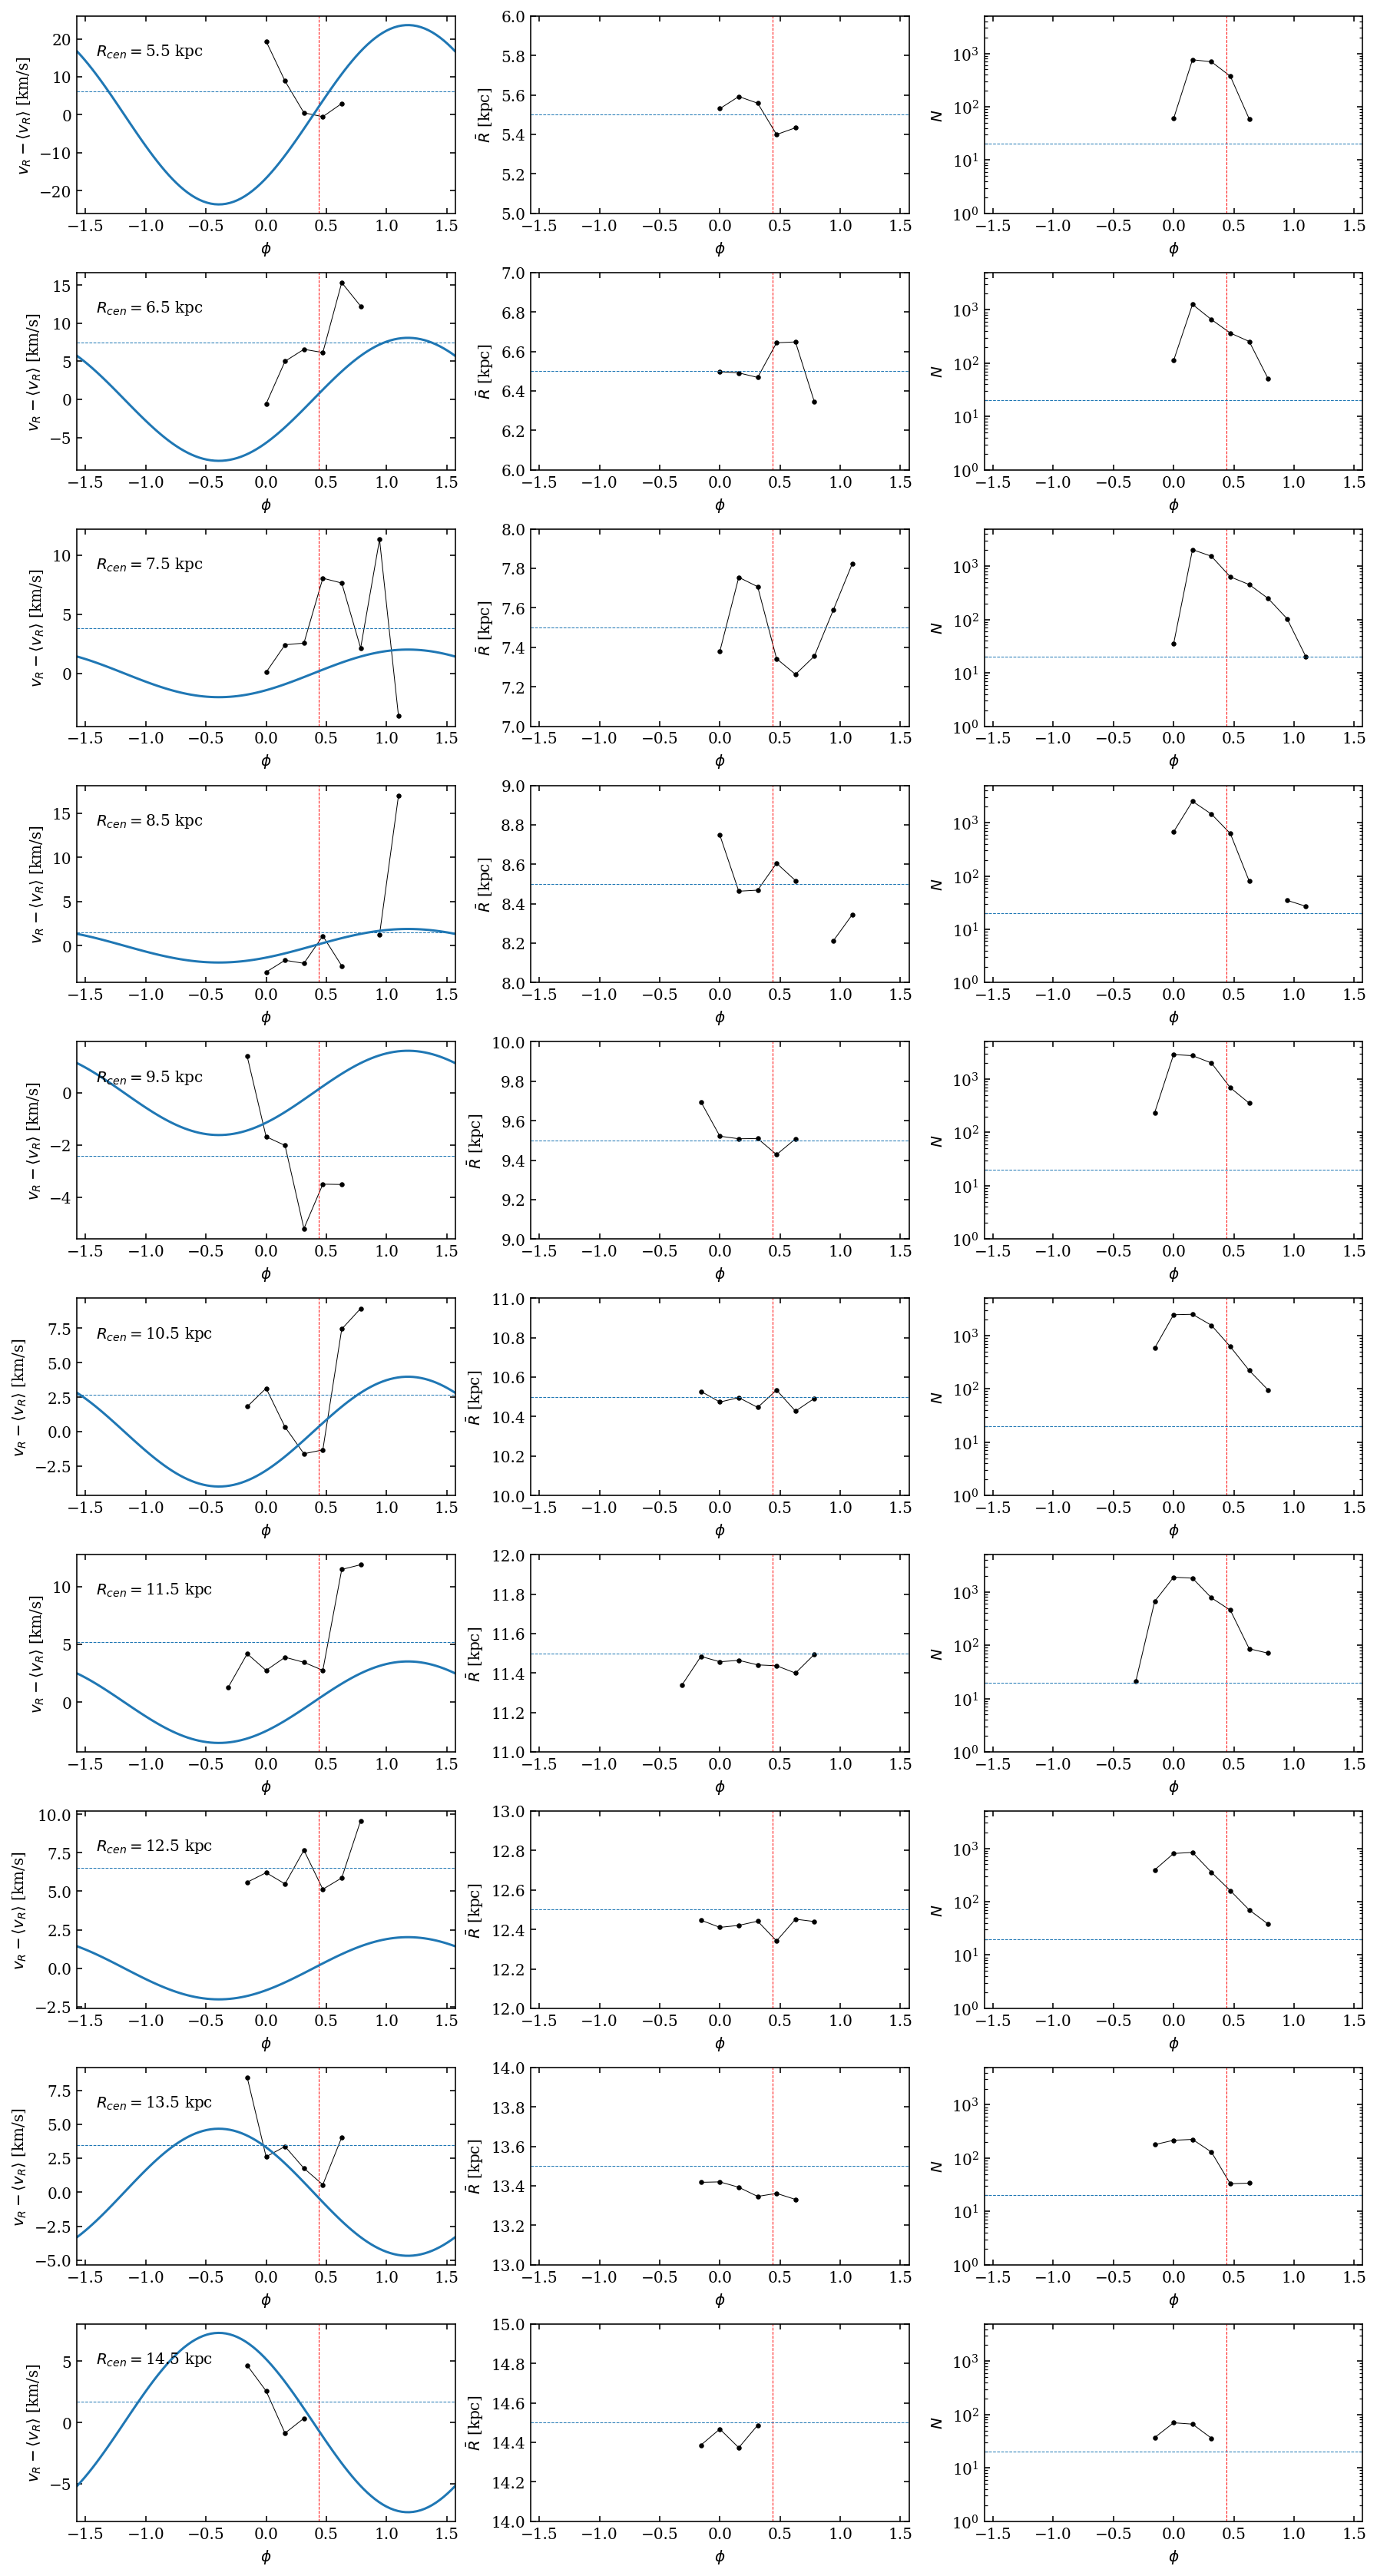

In [24]:
vR_amps = np.zeros(( n_R_bins, 2 ))
vR_bs = np.zeros(( n_R_bins, 2 ))

for i in range(n_R_bins):
    for j in range( n_phib_max ):
        X, SIG_X = determine_best_fitting_m_b(gc_R, gc_phi, gc_vR, R_bin_cents[i], R_bin_size, phib_max[j], 
                                              n_bs=100, force_yint_zero=True, trig_function=np.sin, zero_vels=True)
        vR_bs[i,j] = 0
        vR_amps[i,j] = X[0]
    ###j
###i

fig, axs = radial_velocity_known_m_b_phi( R_bin_cents, R_bin_size, phi_lims, phi_bin_size, gc_R, gc_phi, gc_vR,
                            vR_amps, vR_bs, phib_max, np.sin, phi_bin_size_in_arc=False)

for i in range( len(R_bin_cents) ):
    axs[i,0].set_ylabel(r'$v_{R}- \langle v_{R} \rangle$ [km/s]')
##ax

fig.subplots_adjust( wspace=0.2, hspace=0.3 )

plt.show()

# Try the iterative approach
Add noise into the model by comparing the best-fitting sinusoids with the data, then using that information to generate an extra noise term in each radial bin

In [26]:
def iterate_noise_model(gc_R, gc_phi, gc_vT, gc_vR, R_bin_cents, R_bin_size, phi_bin_cents, phi_bin_size, 
                        phib_bin_cents, n_bs=10, extra_variance=0):
    '''iterate_noise_model:
    
    Args:
    '''
    n_R_bins = len(R_bin_cents)
    n_phi_bins = len(phi_bin_cents)
    n_phib_bins = len(phib_bin_cents)
    extra_variance = np.zeros((n_R_bins,2))
        
    # Make an array to store the log likelihoods
    store_likelihood_vT = np.ones( ( n_R_bins, n_phib_bins ) )
    store_likelihood_vR = np.ones( ( n_R_bins, n_phib_bins ) )

    # Loop over the radii and add
    for j in range( n_R_bins ):

        # Calculate the log likelihood
        likelihood_vT = calculate_phib_likelihood(gc_R, gc_phi, gc_vT, R_bin_cents[j], R_bin_size, 
                                                  phi_bin_cents, phi_bin_size, phib_bin_cents, 
                                                  n_bs=50, force_yint_zero=False, trig_function=np.cos, 
                                                  extra_variance=extra_variance[j,0])
        store_likelihood_vT[j,:] = np.log(likelihood_vT)

        likelihood_vR = calculate_phib_likelihood(gc_R, gc_phi, gc_vR, R_bin_cents[j], R_bin_size, 
                                                  phi_bin_cents, phi_bin_size, phib_bin_cents, 
                                                  n_bs=50, force_yint_zero=True, trig_function=np.sin, 
                                                  extra_variance=extra_variance[j,1])
        store_likelihood_vR[j,:] = np.log(likelihood_vR)

    ###j

    # Marginalize over all radii
    prod_likelihood_vT = np.sum(store_likelihood_vT, axis=0)
    prod_likelihood_vR = np.sum(store_likelihood_vR, axis=0)
    prod_likelihood_both = prod_likelihood_vR + prod_likelihood_vT

    # Determine the best-fitting phib
    phib_max_likelihood_arg = np.argmax( prod_likelihood_both )
    phib_max_likelihood = phib_bin_cents[phib_max_likelihood_arg]

    ms = np.zeros( (n_R_bins,2) )
    bs = np.zeros( (n_R_bins,2) )
    variance_model_data = np.zeros((n_R_bins,2))

    # Loop over radial bins, calculate the 
    for j in range( n_R_bins ):

        # Now determine the best-fitting m and b
        X_vT, SIG_X_vT = calculate_best_fit_m_b(gc_R, gc_phi, gc_vT, R_bin_cents[j], R_bin_size, 
                                                phi_bin_cents, phi_bin_size,
                                                phib_max_likelihood, n_bs=n_bs, 
                                                force_yint_zero=False, 
                                                trig_function=np.cos, 
                                                extra_variance=extra_variance[j,0])
        X_vR, SIG_X_vR = calculate_best_fit_m_b(gc_R, gc_phi, gc_vR, R_bin_cents[j], R_bin_size, 
                                                phi_bin_cents, phi_bin_size,
                                                phib_max_likelihood, n_bs=n_bs, 
                                                force_yint_zero=True, 
                                                trig_function=np.sin, 
                                                extra_variance=extra_variance[j,1])

        bs[j,0] = X_vT[0]
        bs[j,1] = 0
        ms[j,0] = X_vT[1]
        ms[j,1] = X_vR[0]

        # Now calculate the standard deviation of the difference between the data and the model
        variance_model_data[j,0] = calculate_variance_data_model(gc_R, gc_phi, gc_vT, R_bin_cents[j], 
                                                                 R_bin_size, phi_bin_cents, phi_bin_size, 
                                                                 n_bs, ms[j,0], bs[j,0], phib_max_likelihood, 
                                                                 trig_function=np.cos)
        variance_model_data[j,1] = calculate_variance_data_model(gc_R, gc_phi, gc_vR, R_bin_cents[j], 
                                                                 R_bin_size, phi_bin_cents, phi_bin_size, 
                                                                 n_bs, ms[j,1], bs[j,1], phib_max_likelihood, 
                                                                 trig_function=np.sin)
    ###j 
    
    return store_likelihood_vT, store_likelihood_vR, prod_likelihood_vT, prod_likelihood_vR,\
            prod_likelihood_both, phib_max_likelihood, bs, ms, variance_model_data

    

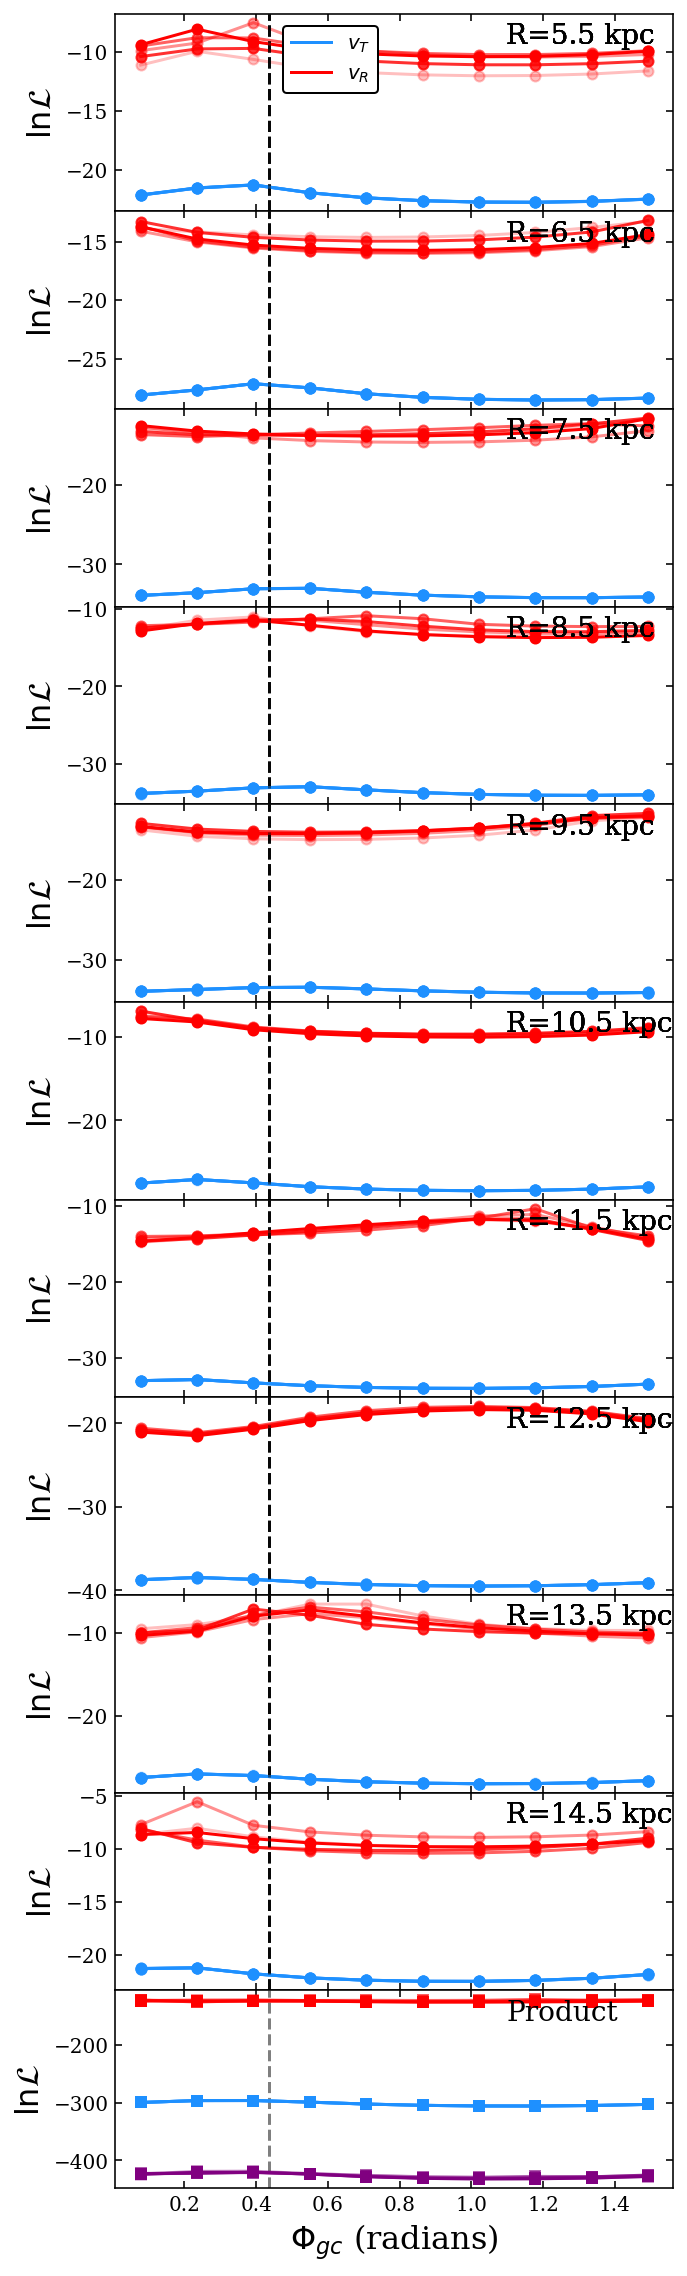

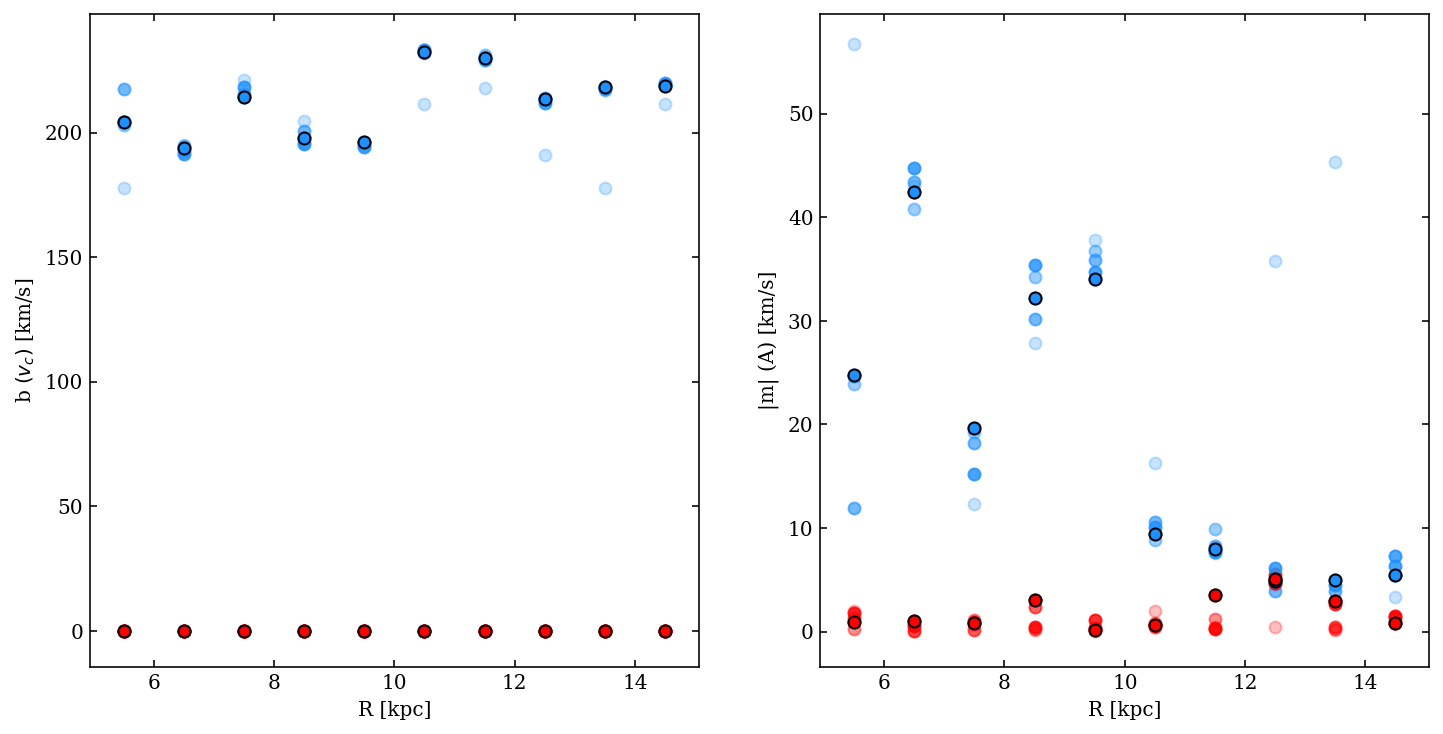

In [29]:
n_R_bins = len(R_bin_cents)
n_phi_bins = len(phi_bin_cents)
n_phib_bins = len(phib_bin_cents)
extra_variance = np.zeros((n_R_bins,2))
n_iterate = 5

alpha_low = 0.25
alpha_increment = (1-alpha_low)/(n_iterate-1)

fig1 = plt.figure( figsize=(5,20) )
axs1 = fig1.subplots( nrows=n_R_bins+1, ncols=1 )

fig2 = plt.figure( figsize=(12,6) ) 
axs2 = fig2.subplots( nrows=1, ncols=2 )

for i in range( n_iterate ):
    
    store_likelihood_vT, store_likelihood_vR, prod_likelihood_vT, prod_likelihood_vR,\
    prod_likelihood_both, phib_max_likelihood, bs, ms, variance_model_data\
    = iterate_noise_model(gc_R, gc_phi, gc_vT, gc_vR, R_bin_cents, R_bin_size, phi_bin_cents, phi_bin_size, 
                          phib_bin_cents, n_bs=10, extra_variance=extra_variance)
    
    extra_variance = variance_model_data
    
    for j in range( n_R_bins ):
        axs1[j].plot( phib_bin_cents, store_likelihood_vT[j,:], marker='o', markersize=5, color='DodgerBlue', 
                      alpha=alpha_low + i*alpha_increment )
        axs1[j].plot( phib_bin_cents, store_likelihood_vR[j,:], marker='o', markersize=5, color='Red', 
                      alpha=alpha_low + i*alpha_increment )
        axs1[j].annotate('R='+str(R_bin_cents[j])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
        axs1[j].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
        axs1[j].axvline( np.pi*25/180, color='Black', linestyle='dashed', alpha=0.5 )
        axs1[j].tick_params(labelbottom='off')
        
    ###i
    
    axs2[0].scatter(R_bin_cents, bs[:,0], edgecolor='DodgerBlue', facecolor='DodgerBlue', 
                    alpha=alpha_low + i*alpha_increment )
    axs2[1].scatter(R_bin_cents, np.abs(ms)[:,0], edgecolor='DodgerBlue', facecolor='DodgerBlue', 
                    alpha=alpha_low + i*alpha_increment )
    axs2[0].scatter(R_bin_cents, bs[:,1], edgecolor='Red', facecolor='Red', 
                    alpha=alpha_low + i*alpha_increment )
    axs2[1].scatter(R_bin_cents, np.abs(ms)[:,1], edgecolor='Red', facecolor='Red', 
                    alpha=alpha_low + i*alpha_increment )
    
    if i == n_iterate-1:
        axs2[0].scatter(R_bin_cents, bs[:,0], edgecolor='Black', facecolor='DodgerBlue', 
                        alpha=alpha_low + i*alpha_increment )
        axs2[1].scatter(R_bin_cents, np.abs(ms)[:,0], edgecolor='Black', facecolor='DodgerBlue', 
                        alpha=alpha_low + i*alpha_increment )
        axs2[0].scatter(R_bin_cents, bs[:,1], edgecolor='Black', facecolor='Red', 
                        alpha=alpha_low + i*alpha_increment )
        axs2[1].scatter(R_bin_cents, np.abs(ms)[:,1], edgecolor='Black', facecolor='Red', 
                        alpha=alpha_low + i*alpha_increment )
    
    if i == 0:
        axs1[0].plot([], [], color='DodgerBlue', label=r'$v_{T}$')
        axs1[0].plot([], [], color='Red', label=r'$v_{R}$')
        axs1[0].legend(loc=(0.3,0.6))
        axs1[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
        axs1[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
        axs1[-1].axvline( np.pi*25/180, color='Black', linestyle='dashed', alpha=0.5 )
        axs1[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
        
        axs2[0].set_xlabel('R [kpc]')
        axs2[0].set_ylabel(r'b $(v_{c})$ [km/s]')
        axs2[1].set_xlabel('R [kpc]')
        axs2[1].set_ylabel(r'|m| (A) [km/s]')
    ###j

    axs1[-1].plot( phib_bin_cents, prod_likelihood_vT, marker='s', markersize=5, color='DodgerBlue', 
                   alpha=alpha_low + i*alpha_increment)
    axs1[-1].plot( phib_bin_cents, prod_likelihood_vR, marker='s', markersize=5, color='Red', 
                   alpha=alpha_low + i*alpha_increment)
    axs1[-1].plot( phib_bin_cents, prod_likelihood_both, marker='s', markersize=5, color='Purple', 
                   alpha=alpha_low + i*alpha_increment)

fig1.subplots_adjust(hspace=0)
plt.show()
pass;